# Determining risk of drift and correcting live audience alignement

The mobile recordings from the Copenhagen concert were from two groups: live in room audience members wearing phones recordings movement through the Musiclab app, and remote participants watching a live stream while wearing these devices. Most participants provided two synchronisation cues, at the begining of the concert and after intermission, that we can use to correct and ajdust their mobile phone recordings to a common "concert time".

For participants in the room, the only challenge to signal alignment is the mobile phone internal clock offset and drift. For participants watching remotely, their alignment to stimulus time may also be complicated by discontinuities in the streaming signal. The concert was streamed over youtube, allowing easy access to people around the world, but this common point of distribution may still be disrupted by variation in stream integrity as well as delays. 

In order to estimate the impact of streaming variation on the quality of alignment we can establish with the synch cues, we first look at the quality of alignment in the live audience. With this data we can estimate the variability typical for mobile phones. The distribution of phone models and types may not be the same as the remote audience but it should be enough to give a sense of the risks. 

Once typical phone variability is determined, we can look more closely at the synchronisation cues in the remote audience and decide which correction strategy would be least compromising on signal quality.

## prep libraries and definitions

In [1]:

import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
def part_trail_pull(part_data,Start_time,End_time):
    # sample rate hard coded for now
    ts_dt = pd.date_range(pd.to_datetime(Start_time), pd.to_datetime(End_time), freq='100ms')
    ts_ts = np.arange(pd.to_datetime(Start_time).timestamp(), pd.to_datetime(End_time).timestamp(), 0.1)*1000

    resampled = pd.DataFrame(index = ts_dt[:-1])
    cols = part_data.columns
    for col in cols[1:]:
        f = interpolate.interp1d(part_data['timestamp'], part_data[col],fill_value='extrapolate')
        resampled[col] = f(ts_ts)
        
    return resampled

def nannotime(row,shift):
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            r[c] = np.nan
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and timestamps which is used to ID gaps greater than gap_T
    # rows of NaN data is added to non-time columns before the first sample, in each gap, and after the last sample of data
    deltat = round(0.35*data.time.diff().median())
    
    data = data.append(nannotime(data.iloc[-1,:],+deltat),ignore_index=True)
    
    dt = data['time'].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat))

    data = data.append(nannotime(data.iloc[0,:],-1)).sort_values('time',ignore_index=True)
    return data

# Prepare synch cues

In [3]:
# set the sampling period for the concert in UTC 
Start_time = '2021-10-26 17:30:00+0000'
End_time = '2021-10-26 20:30:00+0000'

ts_dt = pd.date_range(pd.to_datetime(Start_time), pd.to_datetime(End_time), freq='20ms')
ts_ts = np.arange(pd.to_datetime(Start_time).timestamp(), pd.to_datetime(End_time).timestamp(), 0.02)*1000

In [8]:
ts_ts[1]

1635269400020.0

In [10]:
ts_dt[1]

Timestamp('2021-10-26 17:30:00.020000+0000', tz='UTC', freq='20L')

In [4]:
concert_times = pd.read_csv('C:/Users/finnu/dev/MobileMotion_MusicLab/rebeeps.csv',",") #SV alignment for beeps
concert_times['S_AudioTime'] = 2*np.round(concert_times["TIME"]/2,2) # reset to 50 hz
concert_times['event'] = concert_times["LABEL"]

concert_times['CTime'] = concert_times['S_AudioTime']-concert_times.loc[38,'S_AudioTime'] # zero on onset of first synch cue
concert_times['StimTime'] = pd.to_timedelta(concert_times['CTime'],unit = 's')
concert_times['ConcertdTime'] = concert_times['StimTime'] + ts_dt[54300]
concert_times=concert_times.set_index('ConcertdTime', drop=True)


In [5]:
concert_times

,TIME,LABEL,S_AudioTime,event,CTime,StimTime
ConcertdTime,,,,,,
2021-10-26 17:36:34.760000+00:00,946.00,Claps on,946.00,Claps on,-691.24,-1 days +23:48:28.760000
2021-10-26 17:36:51.880000+00:00,963.13,Claps off,963.12,Claps off,-674.12,-1 days +23:48:45.880000
2021-10-26 17:36:52.880000+00:00,964.11,Speach Danish,964.12,Speach Danish,-673.12,-1 days +23:48:46.880000
2021-10-26 17:37:09.880000+00:00,981.12,Speach English,981.12,Speach English,-656.12,-1 days +23:49:03.880000
2021-10-26 17:37:20.400000+00:00,991.64,Speach Danish,991.64,Speach Danish,-645.60,-1 days +23:49:14.400000
...,...,...,...,...,...,...
2021-10-26 20:02:08.240000+00:00,9679.49,Claps on,9679.48,Claps on,8042.24,0 days 02:14:02.240000
2021-10-26 20:02:30.040000+00:00,9701.27,Claps iso,9701.28,Claps iso,8064.04,0 days 02:14:24.040000
2021-10-26 20:03:55.280000+00:00,9786.51,Claps off,9786.52,Claps off,8149.28,0 days 02:15:49.280000


In [5]:
# first interval with synch cues
t_range1 = [ts_dt[53000],ts_dt[62000]]
aud_df = pd.DataFrame(index = ts_dt[:-1])
sec_df = aud_df.loc[t_range1[0]:t_range1[1],:]

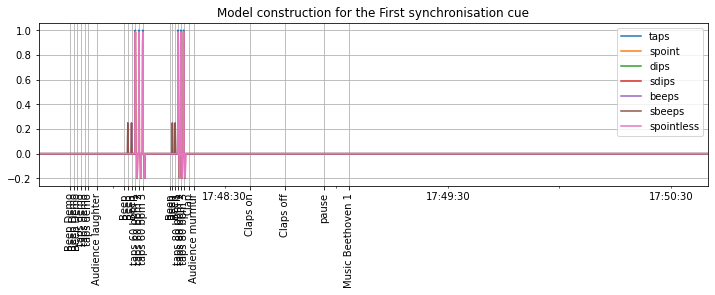

In [6]:
# cues for synchronisation taps 1
cues = pd.DataFrame(index = sec_df.index)
sampleshift = cues.index.to_series().diff().median()

cues['taps'] = 0
cues.loc[concert_times.index[38],'taps'] = 1
cues.loc[concert_times.index[39],'taps'] = 1
cues.loc[concert_times.index[40],'taps'] = 1
cues.loc[concert_times.index[44],'taps'] = 1
cues.loc[concert_times.index[45],'taps'] = 1
cues.loc[concert_times.index[46],'taps'] = 1
cues['spoint'] = cues['taps'].rolling(8, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()

cues['dips'] = 0
dip_shift = 25
cues.loc[concert_times.index[38]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[39]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[40]+dip_shift*sampleshift,'dips'] = -0.2
dip_shift = 20
cues.loc[concert_times.index[44]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[45]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[46]+dip_shift*sampleshift,'dips'] = -0.2
cues['sdips'] = cues['dips'].rolling(20, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()


cues['beeps'] = 0
cues.loc[concert_times.index[35],'beeps'] = 0
cues.loc[concert_times.index[36],'beeps'] = 0.25
cues.loc[concert_times.index[37],'beeps'] = 0.25
cues.loc[concert_times.index[41],'beeps'] = 0
cues.loc[concert_times.index[42],'beeps'] = 0.25
cues.loc[concert_times.index[43],'beeps'] = 0.25

cues['sbeeps'] = cues['spoint'] + cues['beeps'].rolling(12, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()
cues['spointless'] =  cues['spoint'] + cues['sdips']

cues[cues.isna()] = 0
cues.plot(figsize = [12,3]) # 2 is nice
plt.xticks(concert_times.index,concert_times.event, rotation='vertical')
plt.grid()
plt.xlim(t_range1)
plt.title('Model construction for the First synchronisation cue')
plt.savefig('synch1_cues.png')
plt.show()

cues1 = cues.copy()
cues1['time_concert'] = np.arange(0,180.02, 0.02)*1000 + -26000.0

In [7]:
cues1['time'] = cues1.index
cues1

,taps,spoint,dips,sdips,beeps,sbeeps,spointless,time_concert,time
2021-10-26 17:47:40+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,-26000.0,2021-10-26 17:47:40+00:00
2021-10-26 17:47:40.020000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,-25980.0,2021-10-26 17:47:40.020000+00:00
2021-10-26 17:47:40.040000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,-25960.0,2021-10-26 17:47:40.040000+00:00
2021-10-26 17:47:40.060000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,-25940.0,2021-10-26 17:47:40.060000+00:00
2021-10-26 17:47:40.080000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,-25920.0,2021-10-26 17:47:40.080000+00:00
...,...,...,...,...,...,...,...,...,...
2021-10-26 17:50:39.920000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,153920.0,2021-10-26 17:50:39.920000+00:00
2021-10-26 17:50:39.940000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,153940.0,2021-10-26 17:50:39.940000+00:00
2021-10-26 17:50:39.960000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,153960.0,2021-10-26 17:50:39.960000+00:00
2021-10-26 17:50:39.980000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,153980.0,2021-10-26 17:50:39.980000+00:00


In [8]:
# second interval with synch cues
t_range2 = [ts_dt[312000],ts_dt[320000]]
sec_df = aud_df.loc[t_range2[0]:t_range2[1],:]

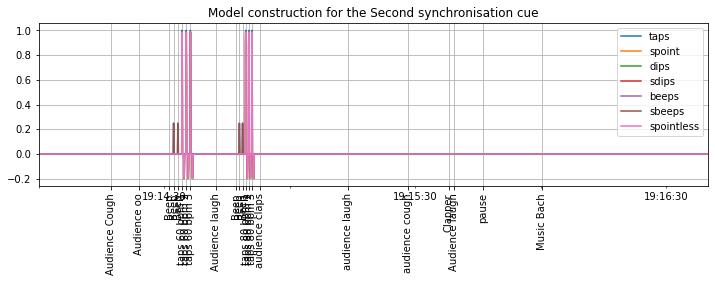

In [9]:
# cues for synchronisation taps 2
# concert_times.iloc[105:121,:] #second set of beeps
cues = pd.DataFrame(index = sec_df.index)
sampleshift = cues.index.to_series().diff().median()

cues['taps'] = 0
cues.loc[concert_times.index[109],'taps'] = 1
cues.loc[concert_times.index[110],'taps'] = 1
cues.loc[concert_times.index[111],'taps'] = 1
cues.loc[concert_times.index[116],'taps'] = 1
cues.loc[concert_times.index[117],'taps'] = 1
cues.loc[concert_times.index[118],'taps'] = 1
cues['spoint'] = cues['taps'].rolling(8, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()

cues['dips'] = 0
dip_shift = 25
cues.loc[concert_times.index[109]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[110]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[111]+dip_shift*sampleshift,'dips'] = -0.2
dip_shift = 20
cues.loc[concert_times.index[116]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[117]+dip_shift*sampleshift,'dips'] = -0.2
cues.loc[concert_times.index[118]+dip_shift*sampleshift,'dips'] = -0.2
cues['sdips'] = cues['dips'].rolling(20, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()


cues['beeps'] = 0
cues.loc[concert_times.index[106],'beeps'] = 0
cues.loc[concert_times.index[107],'beeps'] = 0.25
cues.loc[concert_times.index[108],'beeps'] = 0.25
cues.loc[concert_times.index[113],'beeps'] = 0
cues.loc[concert_times.index[114],'beeps'] = 0.25
cues.loc[concert_times.index[115],'beeps'] = 0.25

cues['sbeeps'] = cues['spoint'] + cues['beeps'].rolling(12, win_type='gaussian', center=True).sum(std=3)#.ewm(span = 5).mean()
cues['spointless'] =  cues['spoint'] + cues['sdips']

cues[cues.isna()] = 0
cues.plot(figsize = [12,3]) # 2 is nice
plt.xticks(concert_times.index,concert_times.event, rotation='vertical')
plt.grid()
plt.xlim(t_range2)
plt.title('Model construction for the Second synchronisation cue')
plt.savefig('synch2_cues.png')

plt.show()
cues2 = cues.copy()
cues2['time_concert'] = (np.arange(0,160.02, 0.02))*1000 -34280.0 + 5188280.0


In [13]:
# save those cue files 
# cues1.to_csv('C:/Users/finnu/dev/MobileMotion_MusicLab/synch1_cues.csv')
# cues2.to_csv('C:/Users/finnu/dev/MobileMotion_MusicLab/synch2_cues.csv')


# Live audience alignment quality 
Review alignment per signal, one by one, to determine cue reliability and final alignent adjustments per device

In [14]:
devFile

'deviceMotion'

In [36]:
# gather the raw recordings for the live performance
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Hall/deviceMotion/'
devices = os.listdir(folder)
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 1000

for devFile in devices:
    if len(devFile)>16: # clearly an installation ID, not another folder
        data = pd.read_csv(folder + '/' + devFile)
        datas = gap_nans(data,gap_t)
        datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))
        
        resampled = pd.DataFrame(index = ts_dt[:-1])
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)
            
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

aud_df.index = ts_dt[:-1]

hall_df = aud_df.copy()

In [40]:
aud_df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
2021-10-26 17:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 17:30:00.020000+00:00,0.887359,2.930785,0.870080,0.514518,2.937995,0.283979,3.764581,0.785236,1.061503,0.583757,...,4.619131,4.703551,9.903192,1.263213,0.447916,0.576483,2.609412,NaN,0.883230,7.070006
2021-10-26 17:30:00.040000+00:00,1.539939,1.879808,0.451236,0.773042,4.811800,0.851893,6.975853,0.415878,2.909512,1.066367,...,11.801654,7.241776,4.444645,0.750831,0.663133,0.563979,6.265110,NaN,0.340852,3.823634
2021-10-26 17:30:00.060000+00:00,1.024732,4.059964,0.804879,0.672187,4.477574,1.825485,5.044543,0.482728,1.079891,0.829336,...,21.413438,5.542271,7.254382,1.708722,0.964123,0.666545,8.878783,NaN,0.869078,2.599896
2021-10-26 17:30:00.080000+00:00,1.145712,4.056735,0.285395,0.638396,8.638909,0.000000,6.710124,0.602420,1.009010,1.274427,...,21.376289,4.182695,5.282365,1.567544,0.996476,0.823077,4.161975,NaN,1.614883,1.545255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 20:29:59.900000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:29:59.920000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:29:59.940000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:29:59.960000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# pull out the section with the synchronisation cues
# first interval with synch cues
sec1_df = hall_df.loc[t_range1[0]:t_range1[1],:]
# second interval with synch cues
sec2_df = hall_df.loc[t_range2[0]:t_range2[1],:]

In [42]:
# prep the recording of alignment decisions
sampleshift = cues.index.to_series().diff().median()
sampleshift_s = sampleshift.total_seconds()
cue_type =  'spointless'
length1 = np.min([len(sec1_df),len(cues1)])
length2 = np.min([len(sec2_df),len(cues2)])

devs = sec1_df.columns # list of signals to consider
synch_offs = pd.DataFrame(index = devs, columns = ["s1_corr0","s1_corr_offset","s1_offset","s2_corr0","s2_corr_offset","s2_offset","devID"])

dev_n = 0

## Cycle through 

['19', 'spointless', 0.41605832125668313, 1, 0.02, 4001, 80.02]


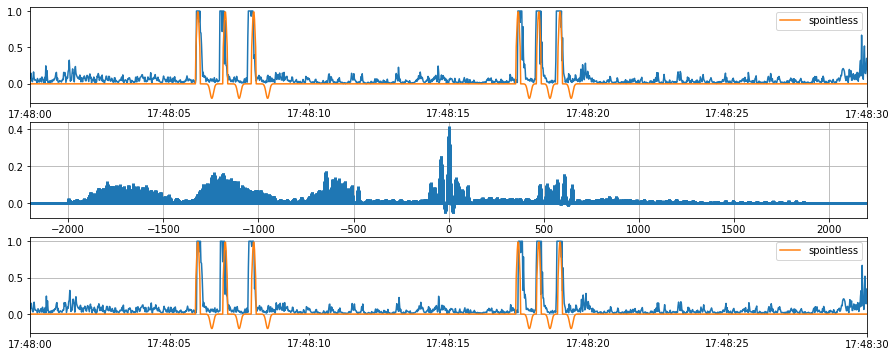

['19', 'spointless', 0.16384064406912013, 757, 15.14, 4001, 80.02]


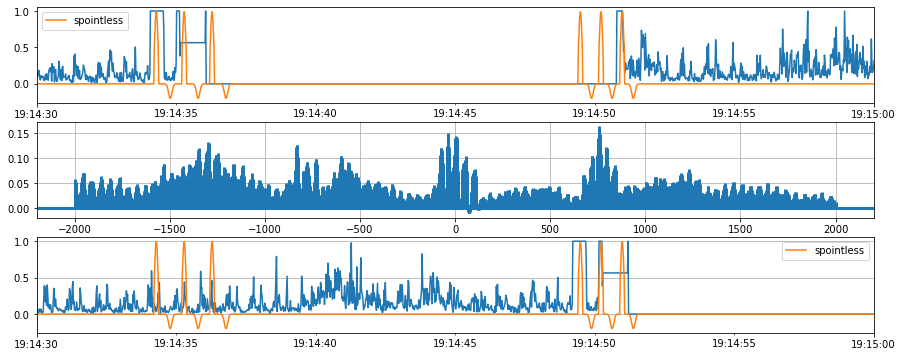

[1, 757]
31f4e1a5-be17-3a37-ee86-1e215ffcb996.Full_Concert.deviceMotion.csv


In [501]:
shifts = []    

# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(15,6))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues1.index[1000],cues1.index[2500]])

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues1[cue_type].iloc[:length1], signal.iloc[:length1], usevlines=True, maxlags=np.min([length1-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    synch_offs.loc[dev_n,'s1_corr0'] = CCC[1][CCC[0]==0][0] # alignment quality without adjustment
    synch_offs.loc[dev_n,'s1_corr_offset'] =np.amax(CCC[1])
    synch_offs.loc[dev_n,'s1_offset'] = sampleshift_s*CCC[0][np.argmax(CCC[1])]

    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    ax1.grid(True)
    #plt.saveas('')
    plt.show()
    #sigs[c] = signal
    CCC1 = CCC
# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(15,6))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues2.index[1500],cues2.index[3000]])

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues2[cue_type].iloc[:length2], signal.iloc[:length2], usevlines=True, maxlags=np.min([length2-1,2000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    #xc = np.correlate(signal.iloc[:length],cues[C2].iloc[:length], "full")
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    synch_offs.loc[dev_n,'s2_corr0'] = CCC[1][CCC[0]==0][0] # alignment quality without adjustment
    synch_offs.loc[dev_n,'s2_corr_offset'] =np.amax(CCC[1])
    synch_offs.loc[dev_n,'s2_offset'] = sampleshift_s*CCC[0][np.argmax(CCC[1])]

    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    ax1.grid(True)
    #plt.saveas('')
    plt.show()
    #sigs[c] = signal
    CCC2 = CCC
    
synch_offs.loc[dev_n,'devID'] = kept_dev[dev_n]
print(shifts)
print(kept_dev[dev_n])

In [ ]:
# edited hall devID 70, d3445962-7716-057f-935c-11a3fb4653a3 from 1.16 to 1.92 approx
# synchalignments.loc[devN,'s1_offset'] = 1.92 


### if that alignment needs manual correction

In [478]:
offs = 2+ 2000 #-1
sub_range = np.arange(0,40)+offs - 10
[CCC1[0][sub_range],CCC1[1][sub_range]]

[array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,
         9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31]),
 array([0.05038355, 0.05508105, 0.0641275 , 0.07459601, 0.0838955 ,
        0.0960995 , 0.10841285, 0.12160679, 0.1377785 , 0.14635852,
        0.14862715, 0.13968932, 0.12546622, 0.10484145, 0.08172898,
        0.06203426, 0.04178471, 0.0324721 , 0.02537544, 0.02359085,
        0.02159616, 0.01952931, 0.01857981, 0.01697875, 0.01710763,
        0.01751719, 0.0156893 , 0.01591502, 0.01561264, 0.0176851 ,
        0.01888419, 0.01921017, 0.02060902, 0.02346763, 0.02577326,
        0.03051575, 0.03346293, 0.03891406, 0.04615656, 0.0527269 ])]

In [479]:
#### correct record of alignmen
shift_true1 = offs #np.argmax(CCC1[1])
print([str(dev_n),cue_type,shift_true1,CCC1[0][shift_true1], (sampleshift_s*CCC1[0][shift_true1]), len(CCC1[0]),len(CCC1[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s1_corr0'] = CCC1[1][CCC1[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s1_corr_offset'] =CCC1[1][shift_true1]
synch_offs.loc[dev_n,'s1_offset'] = sampleshift_s*CCC1[0][shift_true1]

['73', 'spointless', 2002, 2, 0.04, 4001, 80.02]


In [489]:
print('NaN') #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s1_corr0'] = CCC1[1][CCC1[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s1_corr_offset'] =np.nan
synch_offs.loc[dev_n,'s1_offset'] = np.nan

NaN


In [502]:
offs = 6 + 2000
sub_range = np.arange(0,40)+offs - 10
[CCC2[0][sub_range],CCC2[1][sub_range]]

[array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35]),
 array([0.1066304 , 0.11376965, 0.12073282, 0.12740355, 0.13372402,
        0.13751263, 0.14073417, 0.1422013 , 0.14109039, 0.14263864,
        0.14498214, 0.14304998, 0.14022323, 0.13327594, 0.12383633,
        0.10906007, 0.09320882, 0.07449438, 0.05668696, 0.04409161,
        0.03298963, 0.02515808, 0.01815639, 0.01492256, 0.01133777,
        0.00838728, 0.00642786, 0.00498584, 0.00398657, 0.0040795 ,
        0.00556182, 0.0069386 , 0.00902492, 0.01137238, 0.01334258,
        0.01551149, 0.01685585, 0.02150564, 0.03009977, 0.04013014])]

In [503]:
shift_true2 = offs #np.argmax(CCC2[1])
print([str(dev_n),cue_type, shift_true2,CCC2[0][shift_true2], (sampleshift_s*CCC2[0][shift_true2]), len(CCC2[0]),len(CCC2[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s2_corr0'] = CCC2[1][CCC2[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s2_corr_offset'] =CCC2[1][shift_true2]
synch_offs.loc[dev_n,'s2_offset'] = sampleshift_s*CCC[0][shift_true2]

['19', 'spointless', 2006, 6, 0.12, 4001, 80.02]


In [505]:
print('NaN') #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s2_corr0'] = CCC2[1][CCC2[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s2_corr_offset'] =np.nan
synch_offs.loc[dev_n,'s2_offset'] = np.nan

NaN


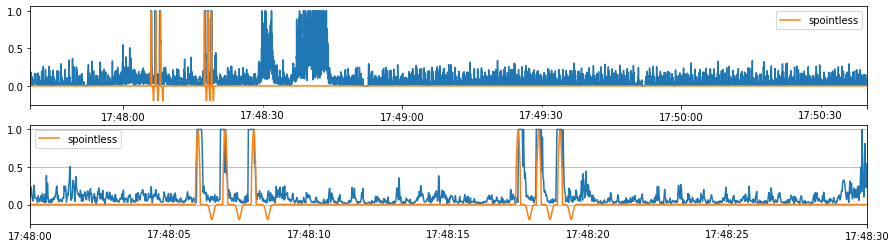

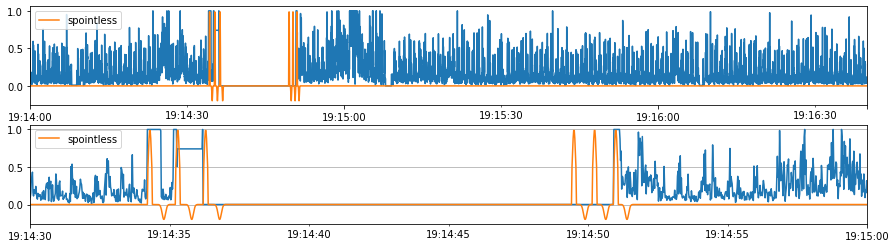

In [504]:
# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.99)
signal = signal/M
signal[signal>1] = 1


fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(211)
signal.plot(ax=ax1)
cues1.plot.line(y=cue_type,ax=ax1)

signal.index = signal.index + pd.Timedelta(synch_offs.loc[dev_n,'s1_offset'],'S')

ax1 = plt.subplot(212)
signal.plot(ax=ax1)
cues1.plot.line(y=cue_type,ax=ax1)
plt.xlim([cues1.index[1000],cues1.index[2500]])
ax1.grid(True)
#plt.saveas('')
plt.show()
#sigs[c] = signal

# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.99)
signal = signal/M
signal[signal>1] = 1

fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(211)
signal.plot(ax=ax1)
cues2.plot.line(y=cue_type,ax=ax1)

signal.index = signal.index + pd.Timedelta(synch_offs.loc[dev_n,'s2_offset'],'S')

ax1 = plt.subplot(212)
signal.plot(ax=ax1)
cues2.plot.line(y=cue_type,ax=ax1)
plt.xlim([cues2.index[1500],cues2.index[3000]])
ax1.grid(True)
#plt.saveas('')
plt.show()


In [506]:
dev_n +=1
synch_offs.to_csv('Hall_synchs_8sample.csv')
synch_offs.iloc[:40,:]

,s1_corr0,s1_corr_offset,s1_offset,s2_corr0,s2_corr_offset,s2_offset,devID
0,0.264428,0.398857,0.06,0.192332,0.313671,0.1,005093c6-7880-8728-1256-26822f05cfb0.Full_Conc...
1,0.191918,0.208169,0.06,0.295367,0.383615,0.1,01393de0-e72e-5e80-f06f-8fdb5d0080cb.Full_Conc...
2,0.258848,0.258848,0.0,0.224764,0.330276,0.22,01d00c32-d4dc-8ce6-353c-43143401adf3.Full_Conc...
3,0.05839,0.16099,0.94,0.0,NaN,NaN,03fcbb15-14c6-b806-80b8-e2c161654dd6.Full_Conc...
4,0.324572,0.342527,0.08,0.26039,0.26039,0.0,04e20480-91d3-cd85-3470-8656b157978f.Full_Conc...
5,0.07443,0.294797,0.62,0.170324,0.324199,0.74,053bd8a0-2ed7-46e9-c088-8eaea2448192.Full_Conc...
6,0.030981,0.087699,0.14,0.202351,0.25109,0.16,0ab9bf2b-a0c7-f823-0fde-6295eedb207e.Full_Conc...
7,0.380346,0.380346,0.0,0.007598,0.603326,0.28,195bb6e0-55ec-d521-d69e-7bfa7cf86b9a.Full_Conc...
8,0.194106,0.270512,0.12,0.27606,0.400493,0.1,1a9a903b-9524-f8c2-a943-81a108880e46.Full_Conc...
9,0.209752,0.209752,0.0,NaN,NaN,NaN,1f6cba0e-36f5-b0c4-8117-00e1608ad7c3.Full_Conc...


In [500]:
dev_n = 19

# Assessing phone clock quality from audience alignment results

In [ ]:
Synchs = pd.read_csv('Hall_synchs.csv')

In [507]:
Synchs = pd.read_csv('Hall_synchs_8sample.csv')

A total of 82 responses have been assessed for synchronisation cues. Their quality varies some. This section evaluates the degree to which devices drifted during the 

In [ ]:
Synchs.loc[49]

In [ ]:
# check which are missing synch cues
Synchs.loc[(Synchs["s2_offset"]).isna(),"devID"]

In [508]:
print(Synchs.mean())
print(Synchs.std())
print(Synchs.min())
print(Synchs.max())

Unnamed: 0        39.500000
s1_corr0           0.167726
s1_corr_offset     0.255907
s1_offset          0.149296
s2_corr0           0.163650
s2_corr_offset     0.338748
s2_offset          0.189118
dtype: float64
Unnamed: 0        23.237900
s1_corr0           0.116632
s1_corr_offset     0.107536
s1_offset          0.527136
s2_corr0           0.124276
s2_corr_offset     0.131808
s2_offset          0.546232
dtype: float64
Unnamed: 0                                                        0
s1_corr0                                                  -0.006934
s1_corr_offset                                             0.025889
s1_offset                                                     -2.44
s2_corr0                                                  -0.062985
s2_corr_offset                                             0.086707
s2_offset                                                     -2.34
devID             005093c6-7880-8728-1256-26822f05cfb0.Full_Conc...
dtype: object
Unnamed: 0          

In [510]:
(Synchs["s2_offset"]-Synchs["s1_offset"]).min()

-0.9

# Remote audience alignment quality 
Review alignment per signal, one by one, to determine cue reliability and final alignent adjustments per device

In [16]:
# gather the raw recordings for the live performance
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Remote/deviceMotion'
devices = os.listdir(folder)
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 1000

for devFile in devices:
    if len(devFile)>10: # clearly an installation ID, not another folder
        datas = gap_nans(pd.read_csv(folder + '/' + devFile),gap_t)
        datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))
        if len(datas)>10000:
            resampled = pd.DataFrame(index = ts_dt[:-1])
            cols = datas.columns
            for col in cols[1:]:
                f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
                resampled[col] = f(ts_ts)

            b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
            if dev_n == 50: # one device has weird stats
                aud_df[dev_n] = b/np.nanmean(b)
            else:
                if np.nanmedian(b)>0:
                    aud_df[dev_n] = b/np.nanmedian(b)
                else:
                    if np.nanmean(b)>0:
                        aud_df[dev_n] = b/np.nanmean(b)
                    else:
                        aud_df[dev_n] = b
            dev_n+=1
            kept_dev.append(devFile)
aud_df.index = ts_dt[:-1]
rem_df = aud_df.copy()

C:\Users\finnu\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\finnu\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\finnu\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\finnu\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\finnu\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [18]:
# pull out the section with the synchronisation cues
# first interval with synch cues
sec1_df = rem_df.loc[t_range1[0]:t_range1[1],:]
# second interval with synch cues
sec2_df = rem_df.loc[t_range2[0]:t_range2[1],:]

In [19]:
# prep the recording of alignment decisions
sampleshift = cues.index.to_series().diff().median()
sampleshift_s = sampleshift.total_seconds()
cue_type =  'spointless'
length1 = np.min([len(sec1_df),len(cues1)])
length2 = np.min([len(sec2_df),len(cues2)])


In [565]:
devs = sec1_df.columns # list of signals to consider
synch_offs = pd.DataFrame(index = devs, columns = ["s1_corr0","s1_corr_offset","s1_offset","s2_corr0","s2_corr_offset","s2_offset","devID"])

dev_n = 0

In [566]:
rem_df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
2021-10-26 17:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 17:30:00.020000+00:00,NaN,NaN,0.159457,NaN,NaN,NaN,NaN,2.467721,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.032818,NaN,NaN,NaN
2021-10-26 17:30:00.040000+00:00,NaN,NaN,0.438264,NaN,NaN,NaN,NaN,3.659085,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.989078,NaN,NaN,NaN
2021-10-26 17:30:00.060000+00:00,NaN,NaN,0.412924,NaN,NaN,NaN,NaN,2.175287,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.478268,NaN,NaN,NaN
2021-10-26 17:30:00.080000+00:00,NaN,NaN,0.296001,NaN,NaN,NaN,NaN,1.574441,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.765730,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26 20:29:59.900000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:29:59.920000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:29:59.940000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26 20:29:59.960000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


## Cycle through 

['45', 'spointless', 0.12010629669863858, -1156, -23.12, 8001, 160.02]


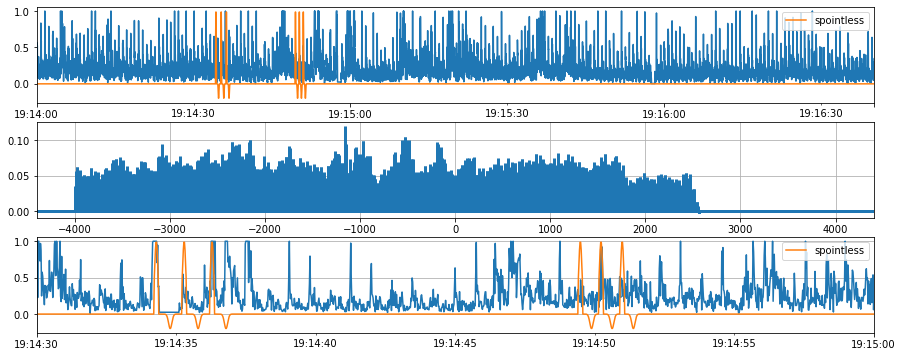

[nan, -1156]
cbda4462-d6ad-c79b-e925-f686517e4fe3.Full_Concert.deviceMotion.csv


In [24]:
shifts = []    

# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.999)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(15,6))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1)
    #plt.xlim([cues1.index[1000],cues1.index[2500]])

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues1[cue_type].iloc[:length1], signal.iloc[:length1], usevlines=True, maxlags=np.min([length1-1,4000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    synch_offs.loc[dev_n,'s1_corr0'] = CCC[1][CCC[0]==0][0] # alignment quality without adjustment
    synch_offs.loc[dev_n,'s1_corr_offset'] =np.amax(CCC[1])
    synch_offs.loc[dev_n,'s1_offset'] = sampleshift_s*CCC[0][np.argmax(CCC[1])]

    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues1.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues1.index[1000],cues1.index[2500]])
    ax1.grid(True)
    #plt.saveas('')
    plt.show()
    #sigs[c] = signal
    CCC1 = CCC
# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.99)
signal = signal/M
signal[signal>1] = 1

if signal.diff().abs().sum()<0.1: # signal is flat
    shifts.append(np.nan)
else: 
    # starting alignment between signal and cue
    fig = plt.figure(figsize=(15,6))
    ax1 = plt.subplot(311)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1)
    #plt.xlim([cues2.index[1500],cues2.index[3000]])

    ax2 = plt.subplot(312)
    CCC = ax2.xcorr(cues2[cue_type].iloc[:length2], signal.iloc[:length2], usevlines=True, maxlags=np.min([length2-1,4000]), normed=True, lw=3)
    ax2.grid(True)
    shifts.append(CCC[0][np.argmax(CCC[1])])
    #xc = np.correlate(signal.iloc[:length],cues[C2].iloc[:length], "full")
    print([str(dev_n),cue_type, np.amax(CCC[1]),CCC[0][np.argmax(CCC[1])], (sampleshift_s*CCC[0][np.argmax(CCC[1])]), len(CCC[0]),len(CCC[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
    synch_offs.loc[dev_n,'s2_corr0'] = CCC[1][CCC[0]==0][0] # alignment quality without adjustment
    synch_offs.loc[dev_n,'s2_corr_offset'] =np.amax(CCC[1])
    synch_offs.loc[dev_n,'s2_offset'] = sampleshift_s*CCC[0][np.argmax(CCC[1])]

    signal.index = signal.index + pd.Timedelta(sampleshift_s*CCC[0][np.argmax(CCC[1])],'S')

    ax1 = plt.subplot(313)
    signal.plot(ax=ax1)
    cues2.plot.line(y=cue_type,ax=ax1)
    plt.xlim([cues2.index[1500],cues2.index[3000]])
    ax1.grid(True)
    #plt.saveas('')
    plt.show()
    #sigs[c] = signal
    CCC2 = CCC
    
synch_offs.loc[dev_n,'devID'] = kept_dev[dev_n]
print(shifts)
print(kept_dev[dev_n])

In [23]:
# edit remote cbda4462-d6ad-c79b-e925-f686517e4fe3.Full_Concert.deviceMotion.csv from -23.12 to 
# synchalignments.loc[devN,'s2_offset'] = -9.68
# edit remote f766dc4c-4363-5b99-678f-5e872b62da6a 25.88 to 27.96
# synchalignments.loc[devN,'s1_offset'] = -27.96
dev_n +=1
dev_n = 45

In [25]:
offs = -484 + 4000 #-1
sub_range = np.arange(0,40)+offs - 10
[CCC1[0][sub_range],CCC1[1][sub_range]]

[array([-494, -493, -492, -491, -490, -489, -488, -487, -486, -485, -484,
        -483, -482, -481, -480, -479, -478, -477, -476, -475, -474, -473,
        -472, -471, -470, -469, -468, -467, -466, -465, -464, -463, -462,
        -461, -460, -459, -458, -457, -456, -455]),
 array([0.01385722, 0.01429442, 0.01440193, 0.01349025, 0.01319617,
        0.01218396, 0.01116665, 0.01039102, 0.00950373, 0.00931321,
        0.00897576, 0.00867285, 0.00886396, 0.00880769, 0.00918374,
        0.01013505, 0.01114283, 0.01183498, 0.01354805, 0.01445281,
        0.01538671, 0.01536136, 0.01620543, 0.01635653, 0.01721734,
        0.01841867, 0.01839533, 0.01870748, 0.01787836, 0.0173031 ,
        0.01546918, 0.0146836 , 0.01398581, 0.01441761, 0.01492079,
        0.01594176, 0.01670692, 0.01644958, 0.01580096, 0.0145178 ])]

In [836]:
# correct record of alignmen
shift_true1 = offs #np.argmax(CCC1[1])
print([str(dev_n),cue_type,shift_true1,CCC1[0][shift_true1], (sampleshift_s*CCC1[0][shift_true1]), len(CCC1[0]),len(CCC1[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s1_corr0'] = CCC1[1][CCC1[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s1_corr_offset'] =CCC1[1][shift_true1]
synch_offs.loc[dev_n,'s1_offset'] = sampleshift_s*CCC1[0][shift_true1]

['53', 'spointless', 2542, -1458, -29.16, 8001, 160.02]


In [861]:
print('NaN') #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s1_corr0'] = CCC1[1][CCC1[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s1_corr_offset'] =np.nan
synch_offs.loc[dev_n,'s1_offset'] = np.nan

NaN


In [26]:
offs = -484 + 4000
sub_range = np.arange(0,40)+offs - 10
[CCC2[0][sub_range],CCC2[1][sub_range]]

[array([-494, -493, -492, -491, -490, -489, -488, -487, -486, -485, -484,
        -483, -482, -481, -480, -479, -478, -477, -476, -475, -474, -473,
        -472, -471, -470, -469, -468, -467, -466, -465, -464, -463, -462,
        -461, -460, -459, -458, -457, -456, -455]),
 array([0.08087339, 0.07950507, 0.07908914, 0.07729667, 0.07769368,
        0.08180219, 0.08625884, 0.09034569, 0.09527534, 0.09946496,
        0.10019065, 0.09253937, 0.08167562, 0.06604137, 0.05040269,
        0.03708263, 0.02564745, 0.01956165, 0.01593928, 0.01589143,
        0.01624447, 0.01643863, 0.01667739, 0.01919598, 0.0208214 ,
        0.02481016, 0.0302713 , 0.03641768, 0.04249618, 0.04874041,
        0.05678167, 0.06257891, 0.06857657, 0.07387767, 0.07271593,
        0.07283883, 0.07121953, 0.06890136, 0.0664018 , 0.06401235])]

In [27]:
shift_true2 = offs #np.argmax(CCC2[1])
print([str(dev_n),cue_type, shift_true2,CCC2[0][shift_true2], (sampleshift_s*CCC2[0][shift_true2]), len(CCC2[0]),len(CCC2[0])*sampleshift_s]) #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s2_corr0'] = CCC2[1][CCC2[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s2_corr_offset'] =CCC2[1][shift_true2]
synch_offs.loc[dev_n,'s2_offset'] = sampleshift_s*CCC[0][shift_true2]

['45', 'spointless', 3516, -484, -9.68, 8001, 160.02]


In [862]:
print('NaN') #,(np.argmax(xc,axis=0)-len(d_Range))/fs,mid
synch_offs.loc[dev_n,'s2_corr0'] = CCC2[1][CCC2[0]==0][0] # alignment quality without adjustment
synch_offs.loc[dev_n,'s2_corr_offset'] =np.nan
synch_offs.loc[dev_n,'s2_offset'] = np.nan

NaN


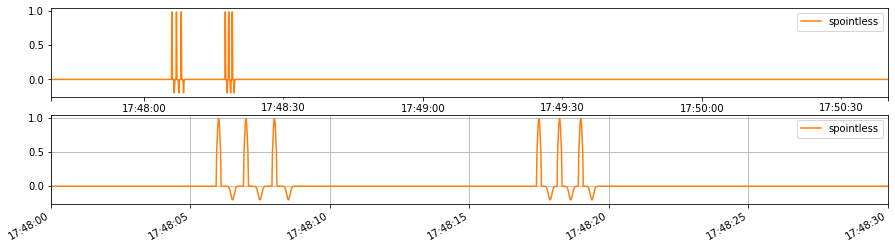

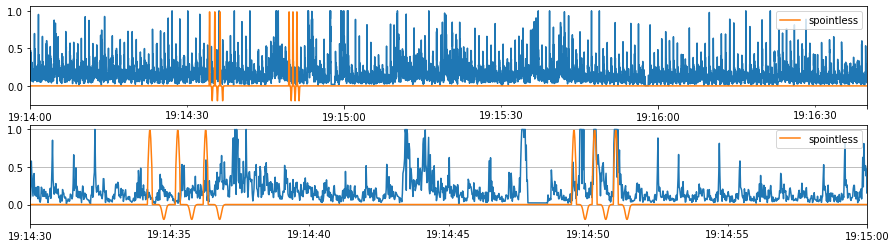

In [28]:
# prep signal for synch 1
signal =sec1_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1


fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(211)
signal.plot(ax=ax1)
cues1.plot.line(y=cue_type,ax=ax1)

signal.index = signal.index + pd.Timedelta(synch_offs.loc[dev_n,'s1_offset'],'S')

ax1 = plt.subplot(212)
signal.plot(ax=ax1)
cues1.plot.line(y=cue_type,ax=ax1)
plt.xlim([cues1.index[1000],cues1.index[2500]])
ax1.grid(True)
#plt.saveas('')
plt.show()
#sigs[c] = signal

# prep signal for synch 1
signal =sec2_df[dev_n].copy()
signal[signal.isna()] = 0
M = signal.quantile(0.995)
signal = signal/M
signal[signal>1] = 1

fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(211)
signal.plot(ax=ax1)
cues2.plot.line(y=cue_type,ax=ax1)

signal.index = signal.index + pd.Timedelta(synch_offs.loc[dev_n,'s2_offset'],'S')

ax1 = plt.subplot(212)
signal.plot(ax=ax1)
cues2.plot.line(y=cue_type,ax=ax1)
plt.xlim([cues2.index[1500],cues2.index[3000]])
ax1.grid(True)
#plt.saveas('')
plt.show()


# Alignment in quality from synch cue


# Hall audience alignment

In [63]:
Synchs = pd.read_csv('Hall_synchs_8sample.csv')
Synchs = Synchs.drop([58,61, 77])# .reset_index(drop = True) # recordings that have no synch cues

In [64]:
print('How many are missing the first synch cue: ' + str((Synchs["s1_offset"]).isna().sum()))
print('How many are missing the second synch cue: ' + str((Synchs["s2_offset"]).isna().sum()))
print('How many have both first and second: ' + str(len(Synchs) - (Synchs["s1_offset"] + Synchs["s2_offset"]).isna().sum()) + ' of ' + str(len(Synchs)))

print('The average difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).mean()))
print('The variance in difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).std()))
print('The max difference from first to second cue: ' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).max()))

align_stats = pd.DataFrame()
align_stats['Means'] = Synchs.mean()
align_stats['Stds'] = Synchs.std()
align_stats['Mins'] = Synchs.min()
align_stats['Maxs'] = Synchs.max()

align_stats = align_stats.drop('Unnamed: 0')
align_stats

How many are missing the first synch cue: 6
How many are missing the second synch cue: 9
How many have both first and second: 62 of 77
The average difference from first to second cue: 0.06612903225806452
The variance in difference from first to second cue: 0.2049418537185743
The max difference from first to second cue: 0.48000000000000004


,Means,Stds,Mins,Maxs
s1_corr0,0.170376,0.117009,-0.006934,0.473395
s1_corr_offset,0.255907,0.107536,0.025889,0.490571
s1_offset,0.149296,0.527136,-2.44,1.84
s2_corr0,0.166834,0.124573,-0.062985,0.523706
s2_corr_offset,0.338748,0.131808,0.086707,0.660242
s2_offset,0.189118,0.546232,-2.34,2.18


Alignment results from the participants in the hall demonstrate the characteristics of the mobile phone clocks and human performance of the synchronisation cue. Most mobile recordings included both the first and second alignent cue, and only 3 had none. 

The cues showed an average drift of 66 ms over the 90ish minutes between the first and second cue, with a standard deviation of 0.20 s. This is smaller than the offsets [0.14, 0.19]s and StD of offsets [0.53, 0.55] s from concert time.

Due to these results, I've chosen to align these recodings without linear rescaling. The cues indicate how much to shift the measurements, a constant adjustment. We do not know the full range of influences that may change the alignment quality of from one cue to the next. The conservative approach is the bring these into the best alignment possible without too many assumptions made.

Based on the assessments of alignment, responses with two cues are adjusted by the offset of the first in the first half of the concert (Start to mid) and offset by the second cue for the second half. Those with only one cue, first or second, are shifted by that one cue for the whole duration of the concert, with the caveat that the resultant alignment may be off by as much as 150 ms by the end. 


<AxesSubplot:>

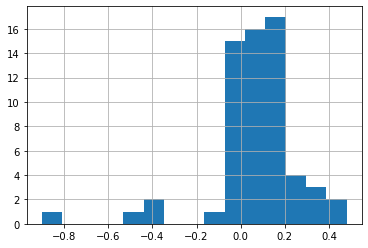

In [69]:
shift_off = Synchs["s2_offset"]-Synchs["s1_offset"]
shift_off.hist(bins = 15)

Scruteny of the tap patterns performed by the hall audience demonstrates the range of interpretation by participants in how they performed the tapping task for synchronisation. 

30 of the 80ish participants performed both sets of triple taps for each cue as instructed. 9 participants insisted on tapping to the entrainment beeps while another 7 performed anticipatory taps to only one or two of the triplets and later corrected. 24 included an extra tap after a sequence at least once. This inconsistent performance judtifies using the two different tempo tapping triplets. One sequence alone would not allow us to distinguish reliably the correct taps from the extras extending the same beat. 

But even with the two tempo safeguard, a few were quite ambiguous. Three recordings did not have even one descernable triple tap with which we might ID the alignment between phone and concert time. 

<AxesSubplot:>

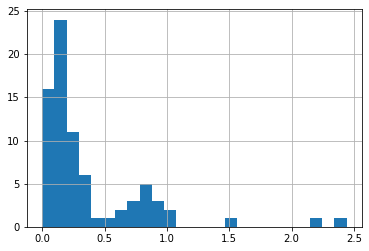

In [41]:
max_off = Synchs[['s1_offset','s2_offset']].abs().max(axis=1,skipna=True)
max_off.hist(bins = 25)

The difference made by the alignment correction for participants in the concert hall was very uneven. Half only needed a shift of less than 200 ms, some of which may only be a consequence of tapping quality, but rest had more substantial deviations. 19, or a quarter of devices, needed shifts of over 500 ms. This is enough to make a difference for many synchrony measures, especially for music (meter) timed movement.

## Remote audience alignment

In [70]:
Synchs = pd.read_csv('Rem_synchs_8sample.csv')
Synchs = Synchs.drop([7,29,55,56]) # recordings from in the room and extra rows
Synchs = Synchs.drop([0,5,9,11,13,20,21,25,32,33,34,35,37,38,43,46,48,50]) # recordings with no synch cues

Synchs = Synchs.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)
Synchs.to_csv('Rem_synchs_8sample_alt.csv',index = False)
Synchs.loc[:10,['s1_offset','s2_offset','devID']]

,s1_offset,s2_offset,devID
1,-11.64,-11.70,06fad321-8a49-062e-1e84-26704be216b8.Full_Conc...
2,-7.18,NaN,09d8163d-80e7-fda3-6919-6a3febc78e27.Full_Conc...
3,NaN,-33.14,10550c8a-ad24-2550-6344-a0f8b85a4739.Full_Conc...
4,-9.34,NaN,1263f72c-512d-d97e-0fb1-561d37f92d7a.Full_Conc...
6,-32.74,NaN,201c5bcf-081c-b8a2-2be3-f62ee4d10c78.Full_Conc...
8,-13.96,NaN,214d0cc9-4279-d09c-77aa-ada046ae803f.Full_Conc...
10,-23.20,NaN,2d115485-bff7-ac99-1682-e3cb88d2f4de.Full_Conc...


In [44]:
print('How many are missing the first synch cue: ' + str((Synchs["s1_offset"]).isna().sum()))
print('How many are missing the second synch cue: ' + str((Synchs["s2_offset"]).isna().sum()))
print('How many have both first and second: ' + str(len(Synchs) - (Synchs["s1_offset"] + Synchs["s2_offset"]).isna().sum()) + ' of ' + str(len(Synchs)))

print('The average difference from first to second cue:' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).mean()))
print('The variance in difference from first to second cue:' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).std()))
print('The max difference from first to second cue:' + str((Synchs["s2_offset"]-Synchs["s1_offset"]).max()))

align_stats = pd.DataFrame()
align_stats['Means'] = Synchs.mean()
align_stats['Stds'] = Synchs.std()
align_stats['Mins'] = Synchs.min()
align_stats['Maxs'] = Synchs.max()
align_stats

How many are missing the first synch cue: 8
How many are missing the second synch cue: 13
How many have both first and second: 14 of 35
The average difference from first to second cue:-0.0314285714285712
The variance in difference from first to second cue:1.6401259667516959
The max difference from first to second cue:4.279999999999998


,Means,Stds,Mins,Maxs
s1_corr0,0.038121,0.047150,0.0,0.233328
s1_corr_offset,0.305046,0.140864,0.101203,0.63428
s1_offset,-17.843704,10.679842,-35.3,-6.32
s2_corr0,0.028269,0.030173,0.000007,0.098143
s2_corr_offset,0.228495,0.096768,0.048423,0.42341
s2_offset,-21.065455,12.196428,-53.84,-7.42


The number of recordings with both cues is much smaller for the remote audience, only 14. Of those that had both, the drift was similar is scale to the in Hall audience (-0.03 s). However the variation was much bigger (std 1.6 s), which may be the consequence of stream buffering issues rather than device variability. Still that variability is substantially less than the offsets neeced for that streaming group [18, 21] s, and variance nearly as large std [11, 12] s.

Here again we align to both cues when both are available, for first and second half, and use any cue when that is an option. Responses without a cue were necessarily dropped as the shift was so substantial. That yeilded 38 remote recordings (with somewhat patchy coverage) that had been aligned to within 0.2 s optimally or 2 s when allowing for downstream buffering effects. 

<AxesSubplot:>

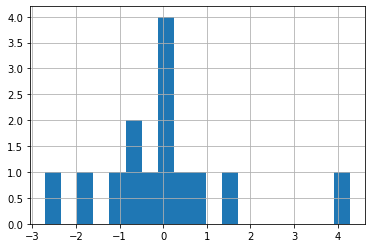

In [61]:
shift_off = Synchs["s2_offset"]-Synchs["s1_offset"]
shift_off.hist(bins = 19)

<AxesSubplot:>

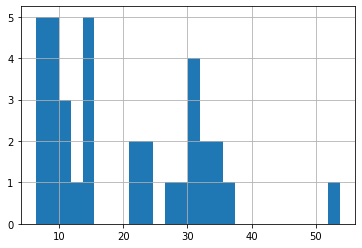

In [50]:
max_off = Synchs[['s1_offset','s2_offset']].abs().max(axis=1,skipna=True)
max_off.hist(bins = 26)

Alignment from the synch cue will make a huge difference for the remote audience. The minimum deviation was of 6.3 seconds delay, with as much as 53.8 seconds. While the variance in deviation in those files with double synch cues suggest some internal variation due to connection discontinuities should be expected, this correction compensate for more than the largest shift within a single file. 